In [211]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

from sklearn.preprocessing import LabelEncoder


import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr


from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, \
    precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve 

import warnings
warnings.filterwarnings('ignore')

In [212]:
pd.options.display.max_columns = None
df=pd.read_csv('loan_data_2007_2014.csv',low_memory=False)

In [213]:
def clean_data(df):
 
    
    ## cols to be dropped
    #'Unnamed: 0'> index to be used
    #'id', 'member_id'> not relevant in creating score card
    #funded_amnt, funded_amnt_inv same as loan amount. To be removed to avoid multicollinearity
    #grade to be dropped as sub-grade is a subset of grade
    #drop title as the purpose column will suffice
    #text attributes to be removed ['url']
    #policy code and application_type have only one unique value
    #last_pymnt_d can't be used during application
    #total_pymnt ,total_pymnt_inv are the same.total_pymnt_inv to be removed
    #emp_title
    
    df.drop(df[['Unnamed: 0','id','member_id','funded_amnt','funded_amnt_inv',
            'grade','url','application_type','title','policy_code','emp_title',
                'pymnt_plan','last_pymnt_d','last_pymnt_amnt','total_pymnt_inv','zip_code','addr_state']],
            axis=1,inplace=True)
    
     #Drop columns with  70% N/A of the data:
    df.dropna(axis='columns', thresh=0.7*len(df),inplace=True)
    
    df['emp_length'].replace({ '10+ years': 10, '< 1 year': 0, '1 year': 1,'2 years': 2,'3 years': 3,'4 years': 4,
    '5 years': 5,'6 years': 6,'7 years': 7,'8 years': 8,'9 years': 9},inplace=True)
    
    
    # Calculate mode of the column
    mode_value = df['emp_length'].mode()[0]

    # Replace missing values with mode
    df['emp_length'] = df['emp_length'].fillna(mode_value)
    
    # Replace all numerical values where NA with -9999
    df[df.select_dtypes(include=['int64', 'float64']).columns] = df.select_dtypes(include=['int64', 'float64']).fillna(-9999)
    
    
    return df

df=clean_data(df)

In [5]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,36 months,10.65,162.87,B2,10.0,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,27.65,0.0,Jan-85,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5000.00,861.07,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0
1,2500,60 months,15.27,59.83,C4,0.0,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,1.00,0.0,Apr-99,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,456.46,435.17,0.00,117.08,1.11,Sep-13,0.0,0.0,-9999.0,-9999.0,-9999.0
2,2400,36 months,15.96,84.33,C5,10.0,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,8.72,0.0,Nov-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,2400.00,603.65,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0
3,10000,36 months,13.49,339.31,C1,10.0,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,20.00,0.0,Feb-96,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,10000.00,2209.33,16.97,0.00,0.00,Jan-15,0.0,0.0,-9999.0,-9999.0,-9999.0
4,3000,60 months,12.69,67.79,B5,1.0,RENT,80000.0,Source Verified,Dec-11,Current,other,17.94,0.0,Jan-96,0.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,2233.10,1009.07,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0


In [214]:
def feat_eng(df):
    # credit history tenure
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
    df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')
    
    

    df['credit_history_tenure_years']=(df['issue_d']-df['earliest_cr_line']).dt.days / 365.25
    df['credit_history_tenure_months'] = (df['issue_d'].dt.to_period('M') - df['earliest_cr_line'].dt.to_period('M'))
    df['credit_history_tenure_months'] = df['credit_history_tenure_months'].apply(lambda x: x.n if x is not pd.NaT else 0)


    df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month

    # Months between issue
    df['credit_pull_months'] = (df['issue_d'].dt.to_period('M') - df['last_credit_pull_d'].dt.to_period('M'))
    df['credit_pull_months'] = df['credit_pull_months'].apply(lambda x: x.n if x is not pd.NaT else 0)
    
    
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']
    

    df.drop(['earliest_cr_line','last_credit_pull_d','last_credit_pull_d'],axis=1,inplace=True)
    return df

df=feat_eng(df)

In [215]:
def good_bad(df):
    
    # assign 0 to bad loans(default) and 1 to good loans
    
    #bad loans
    condition=np.isin(df['loan_status'],['Charged Off','Late (31-120 days)','Late (16-30 days)','Default','Does not meet the credit policy. Status:Charged Off'])
    replace=['0']
    df['loan_status']=np.where(condition,replace,df['loan_status'])
    
    #good loans
    condition2=np.isin(df['loan_status'],['Fully Paid','Does not meet the credit policy. Status:Fully Paid'],)
    replace=['1']
    df['loan_status']=np.where(condition2,replace,df['loan_status'])
    
    ## I will drop status In Grace Period and Current because we are not sure if they will repay the loans or not
    values_to_drop = ['In Grace Period', 'Current']
    df = df[~df['loan_status'].isin(values_to_drop)]
    
    return df


df=good_bad(df)

In [8]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,credit_history_tenure_years,credit_history_tenure_months,earliest_cr_line_month,credit_pull_months,loan_to_income_ratio
0,5000,36 months,10.65,162.87,B2,10.0,RENT,24000.0,Verified,2011-12-01,1,credit_card,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5000.00,861.07,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,26.913073,323,1.0,-49,0.208333
1,2500,60 months,15.27,59.83,C4,0.0,RENT,30000.0,Source Verified,2011-12-01,0,car,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,456.46,435.17,0.00,117.08,1.11,0.0,0.0,-9999.0,-9999.0,-9999.0,12.668036,152,4.0,-21,0.083333
2,2400,36 months,15.96,84.33,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,1,small_business,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,2400.00,603.65,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,10.080767,121,11.0,-49,0.195886
3,10000,36 months,13.49,339.31,C1,10.0,RENT,49200.0,Source Verified,2011-12-01,1,other,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,10000.00,2209.33,16.97,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,15.830253,190,2.0,-37,0.203252
5,5000,36 months,7.90,156.46,A4,3.0,RENT,36000.0,Source Verified,2011-12-01,1,wedding,11.20,0.0,3.0,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5000.00,631.38,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,7.080082,85,11.0,-45,0.138889


In [216]:
df['loan_status'].value_counts()

loan_status
1    186727
0     52186
Name: count, dtype: int64

In [217]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['loan_status'] = pd.to_numeric(df['loan_status'])

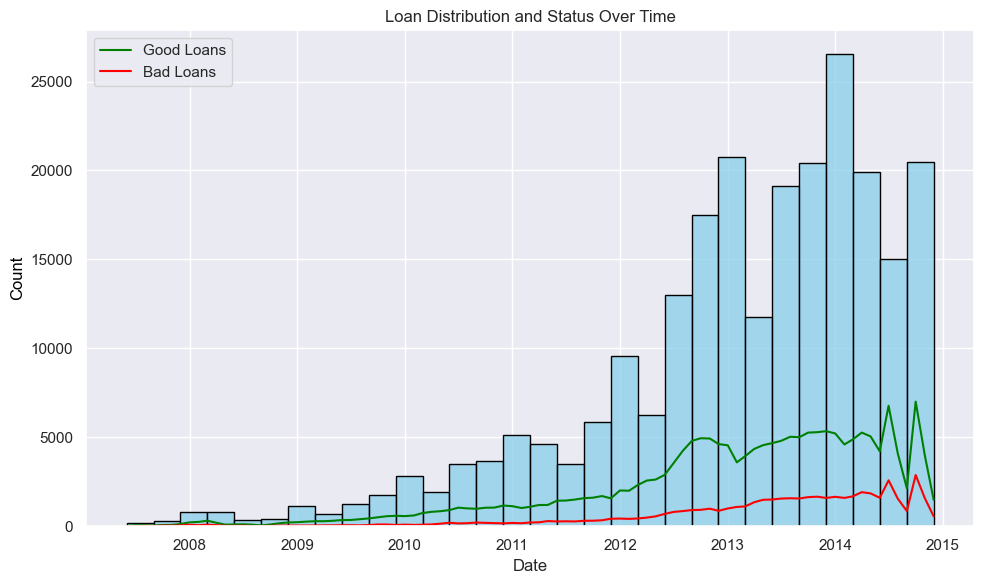

In [218]:
# Plotting
plt.figure(figsize=(10, 6))

# Histogram with loan distribution over time
sns.histplot(data=df, x='issue_d', bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Count', color='skyblue')
plt.title('Loan Distribution and Status Over Time')

# Line plot for good loans
good_loans = df[df['loan_status'] == 1].groupby('issue_d').size().reset_index(name='Count')
sns.lineplot(data=good_loans, x='issue_d', y='Count', color='green', label='Good Loans')

# Line plot for bad loans
bad_loans = df[df['loan_status'] == 0].groupby('issue_d').size().reset_index(name='Count')
sns.lineplot(data=bad_loans, x='issue_d', y='Count', color='red', label='Bad Loans')

 
#plt.axvline(pd.to_datetime('2013-07-01'), color='gray', linestyle='--', linewidth=1)


plt.ylabel('Count', color='black')
plt.legend()
plt.tight_layout()
plt.show()

# Filter issue date to determine sample window

In [219]:
train_start_date = '2010-01-01'
train_end_date = '2013-06-30'
test_start_date = '2013-07-01'
test_end_date = '2013-12-31'

In [220]:
# Split the data into (training data) and (test data)
train = df[(df['issue_d'] >= train_start_date) & (df['issue_d'] <= train_end_date)]
test = df[(df['issue_d'] >= test_start_date) & (df['issue_d'] <= test_end_date)]


print("(Training Data) Size:", len(train))
print("(Test Data) Size:", len(test))

(Training Data) Size: 115312
(Test Data) Size: 40312


In [221]:
train.drop(['issue_d'],inplace=True,axis=1)

In [222]:
X_train=train.drop('loan_status',axis=1)
y_train=train['loan_status']
X_test=test.drop('loan_status',axis=1)
y_test=test['loan_status']

# Binning

In [223]:
#specify binning requirements
combiner = toad.transform.Combiner()
combiner.fit(X_train, y_train,   method='dt', min_samples = 0.05)

bins = combiner.export()

#apply binning on both the train and test datasets
X_train = combiner.transform(X_train)
X_test = combiner.transform(X_test[X_train.columns])

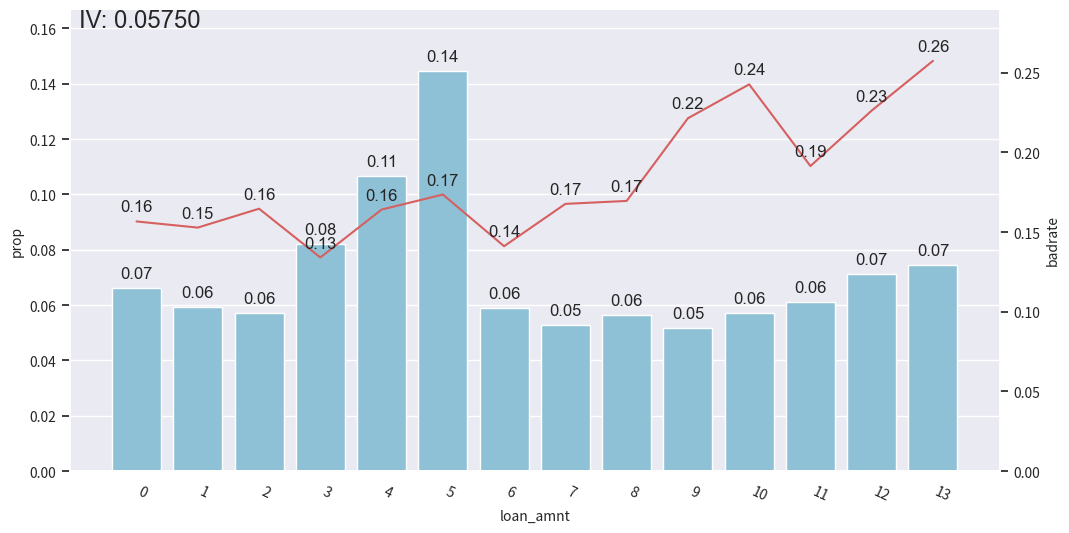

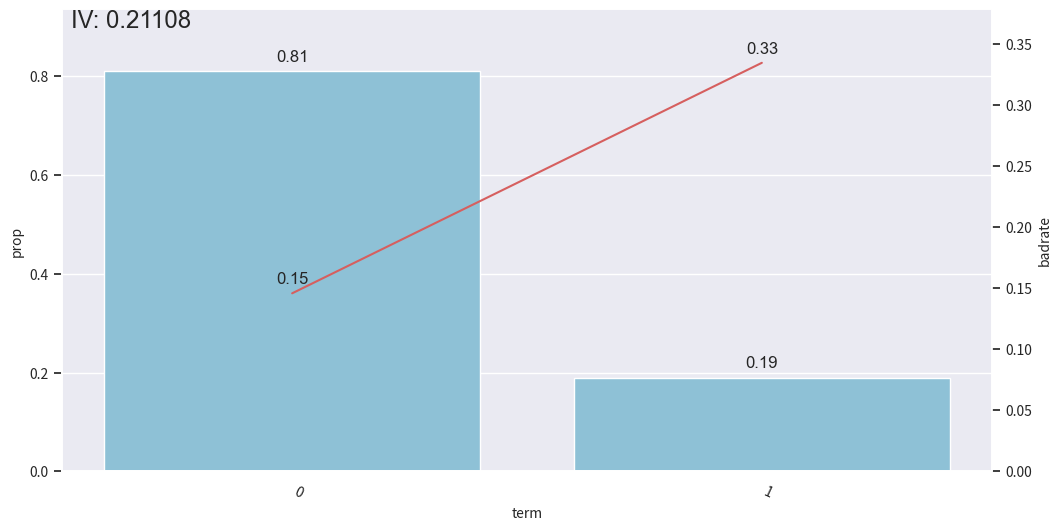

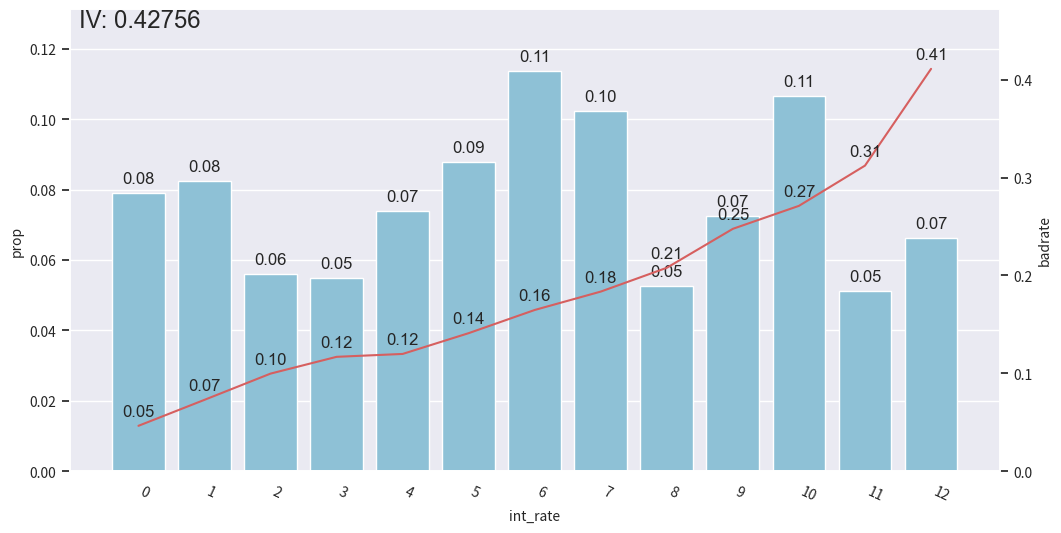

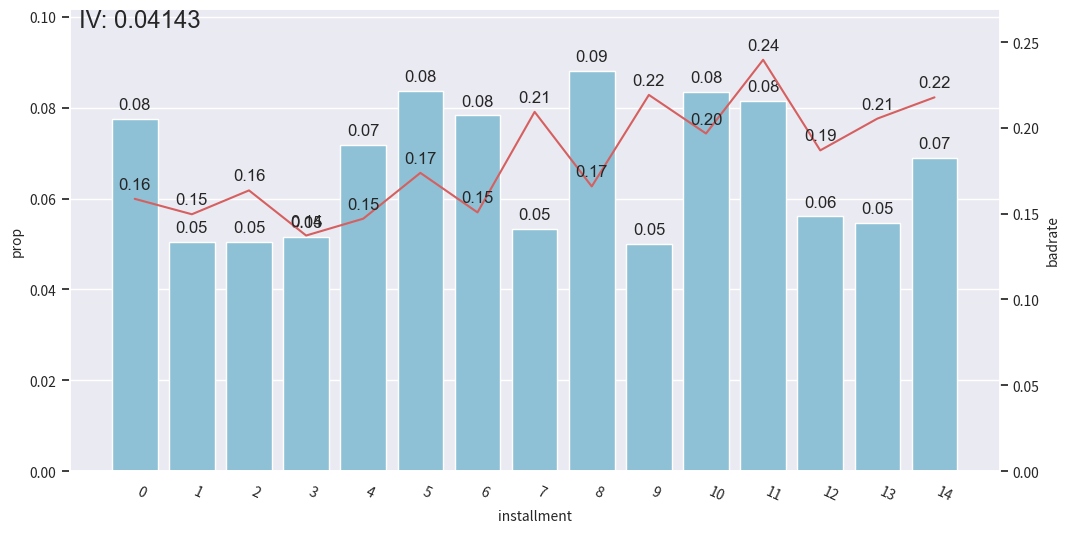

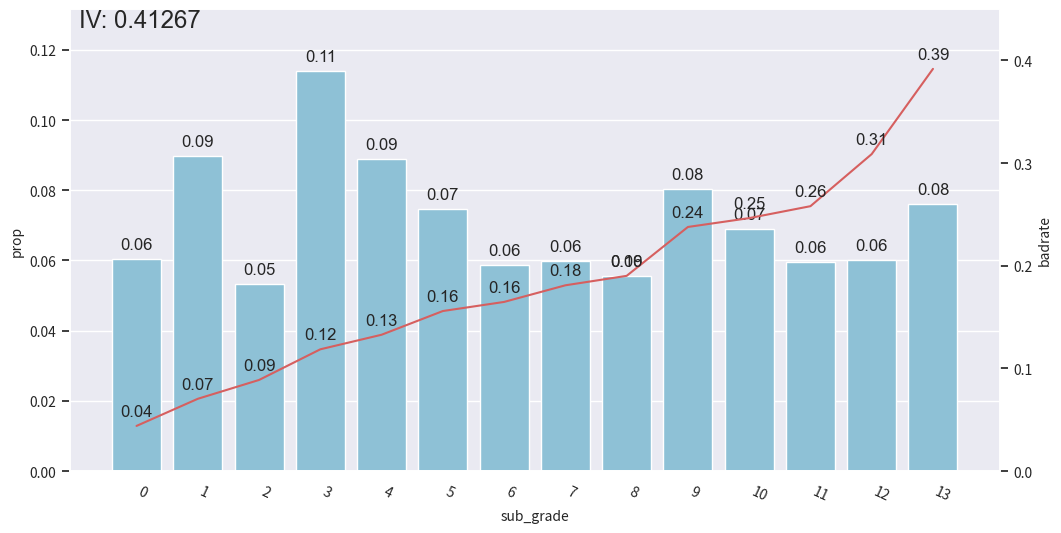

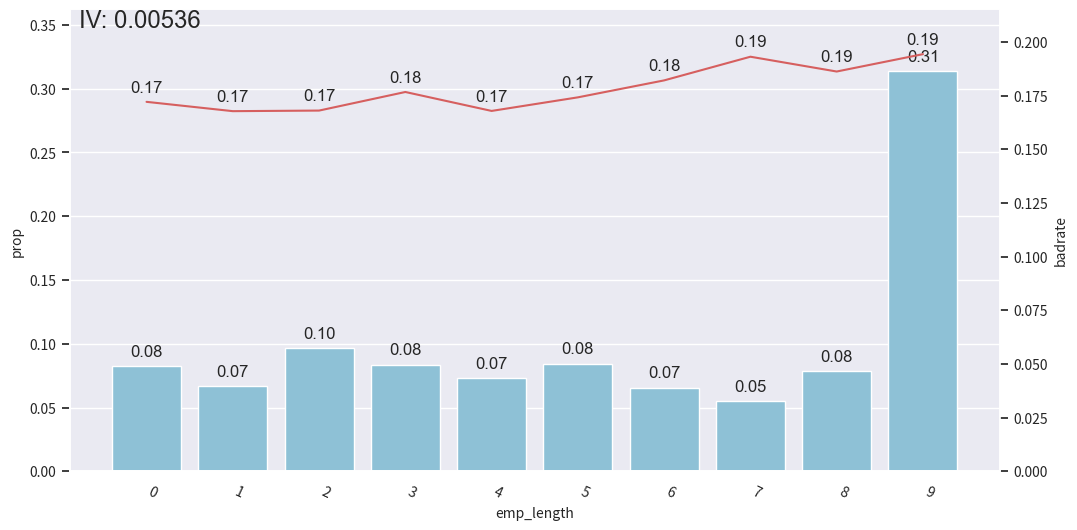

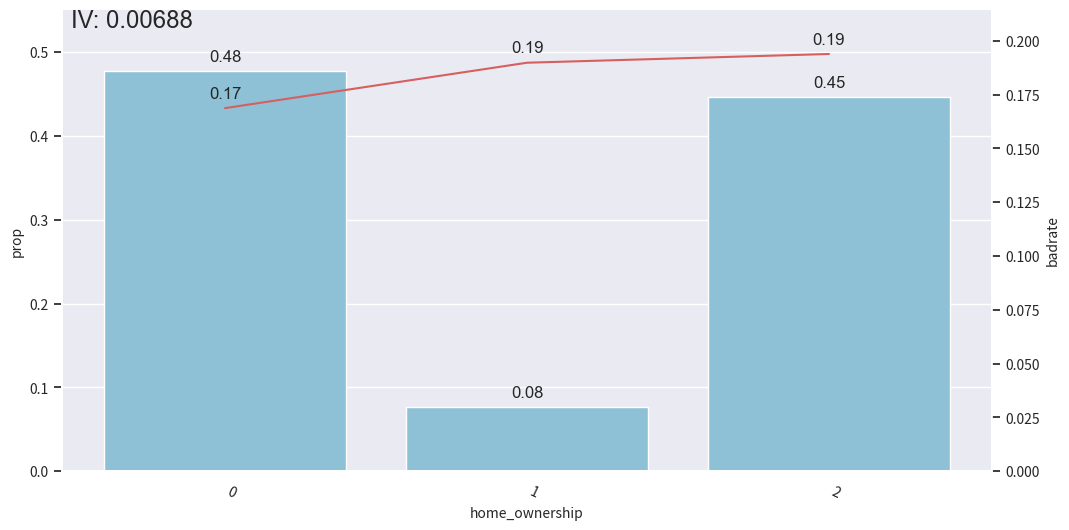

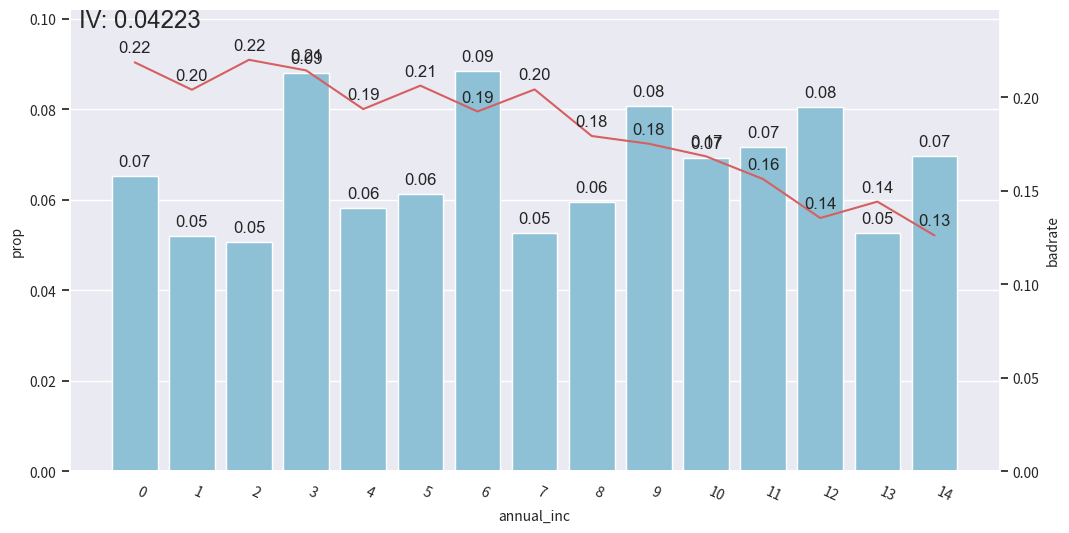

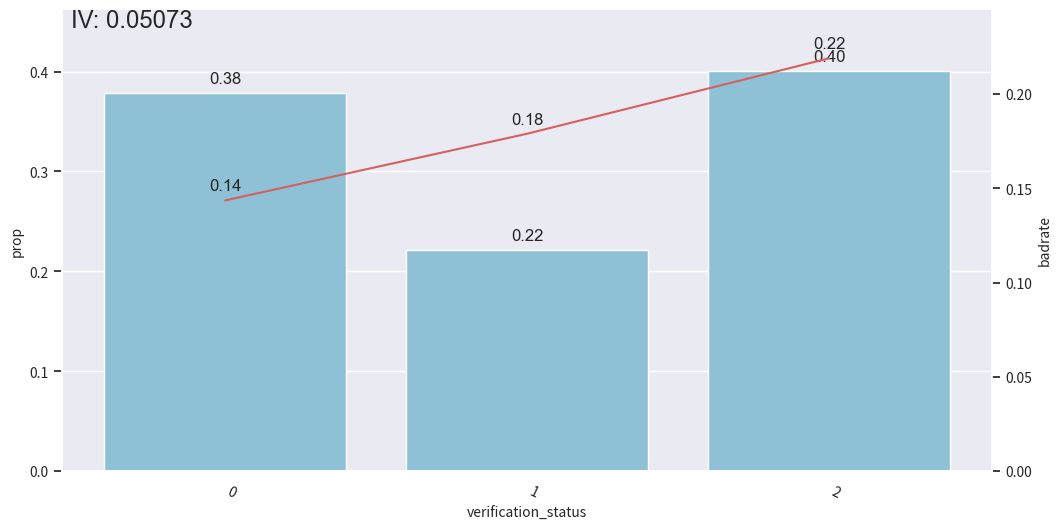

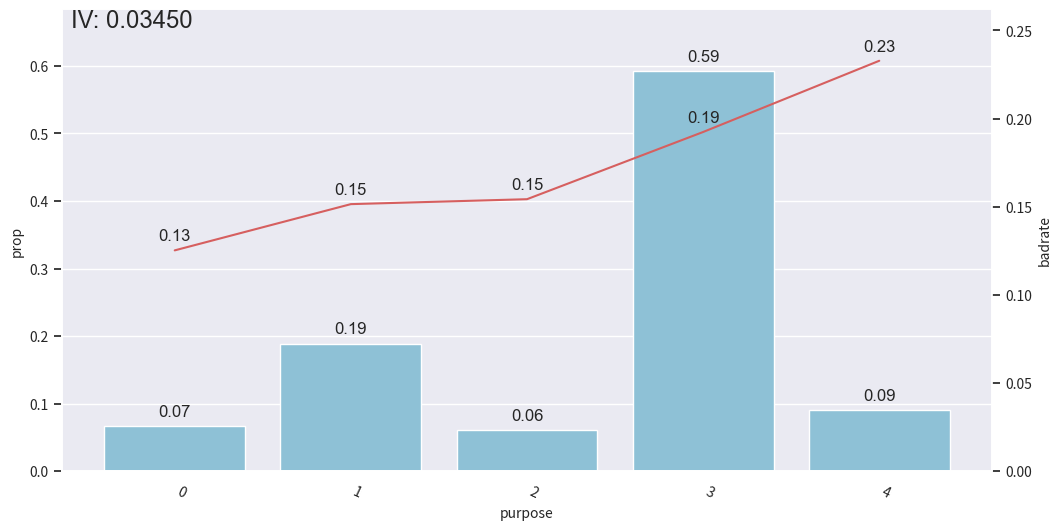

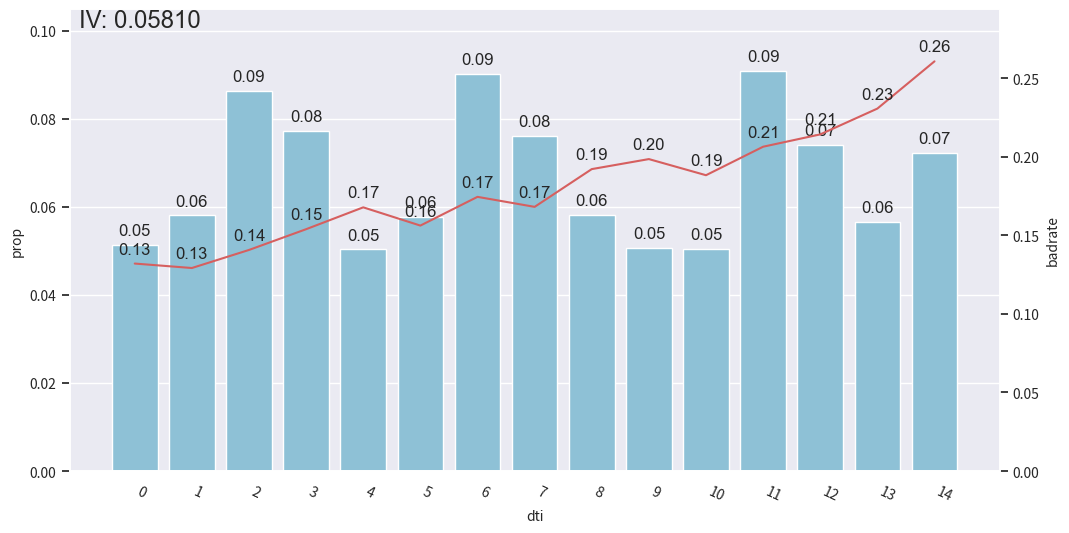

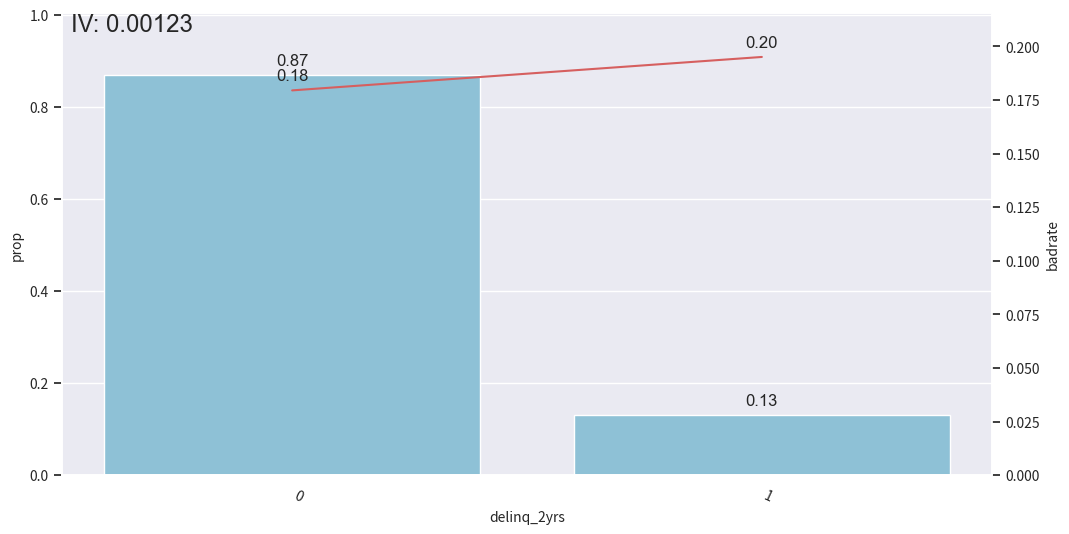

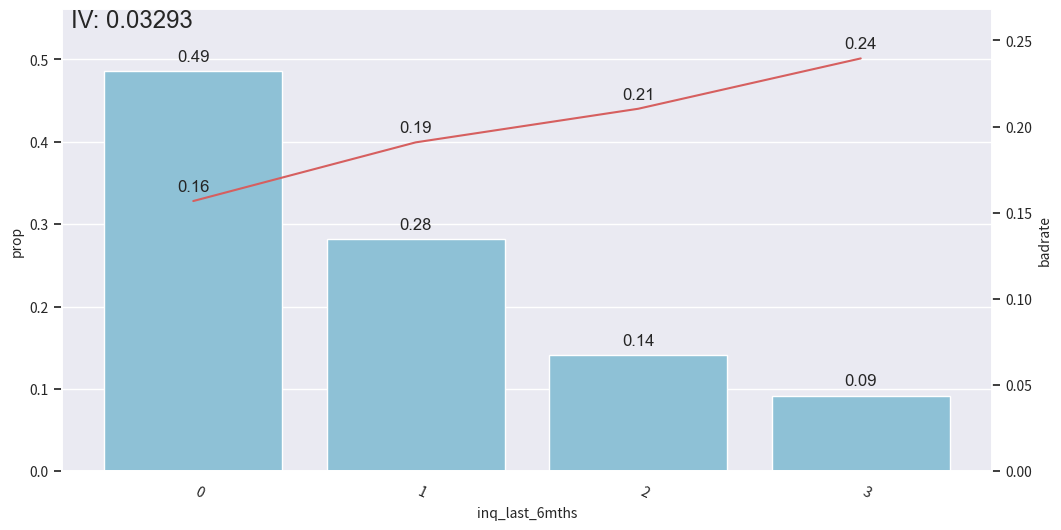

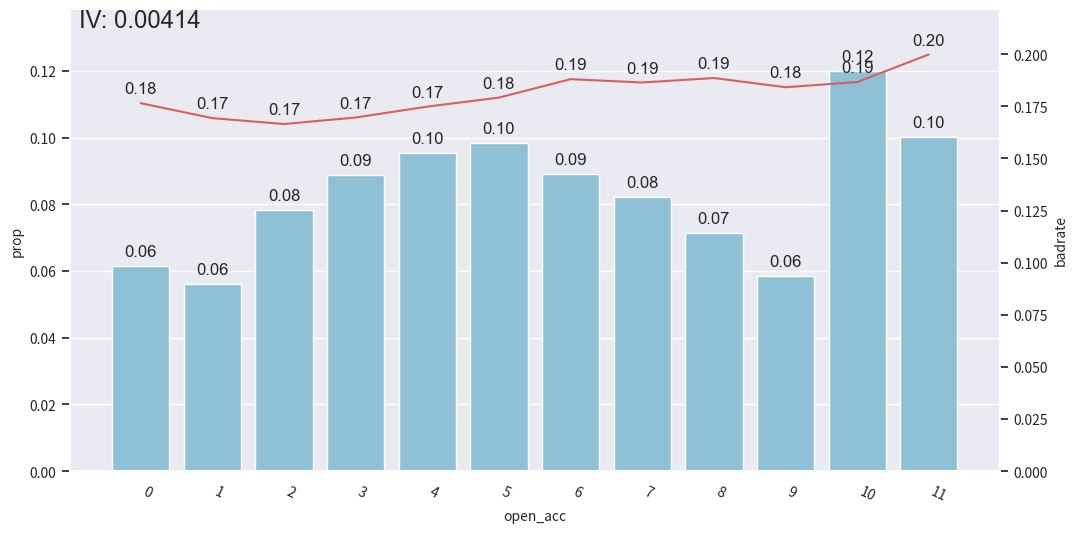

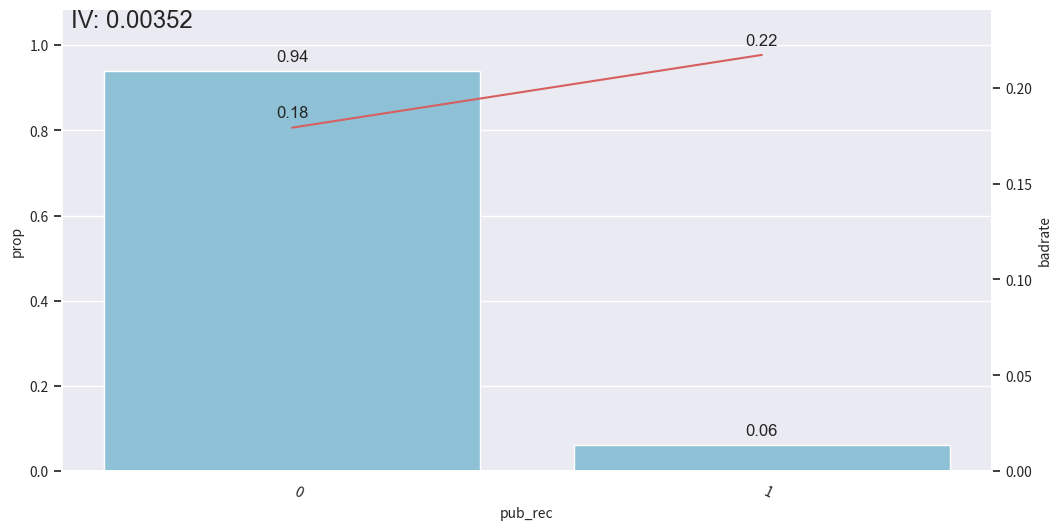

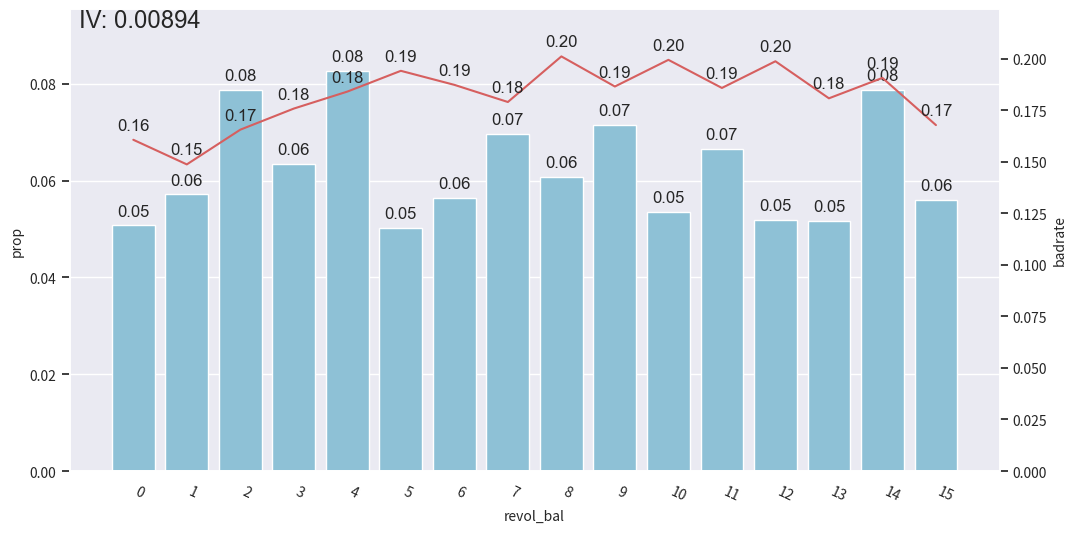

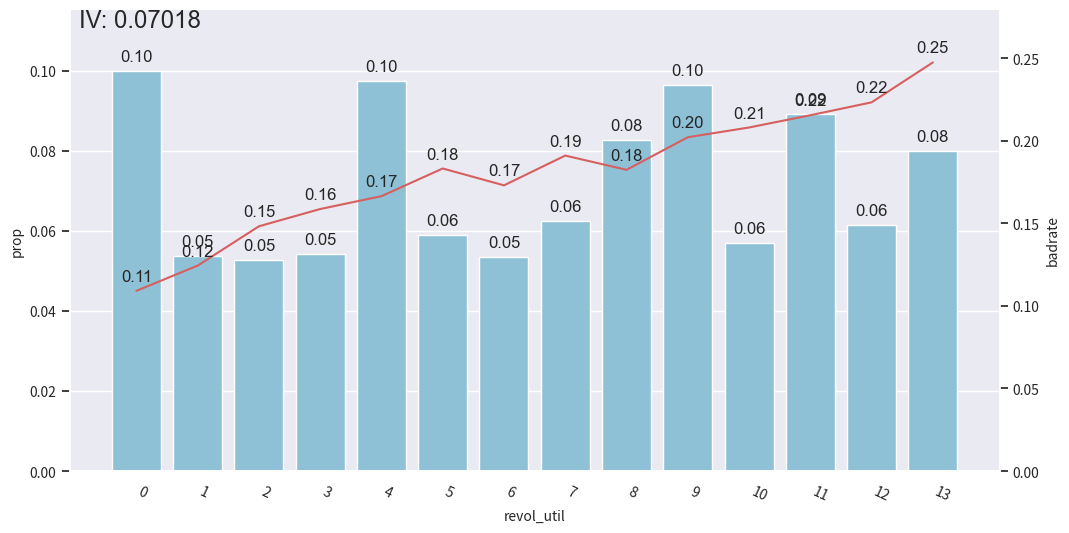

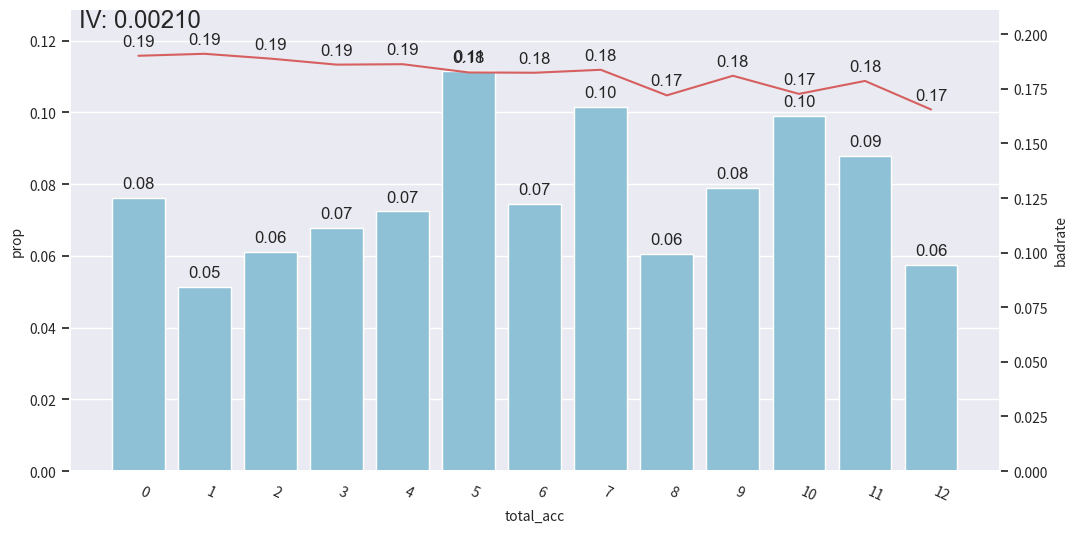

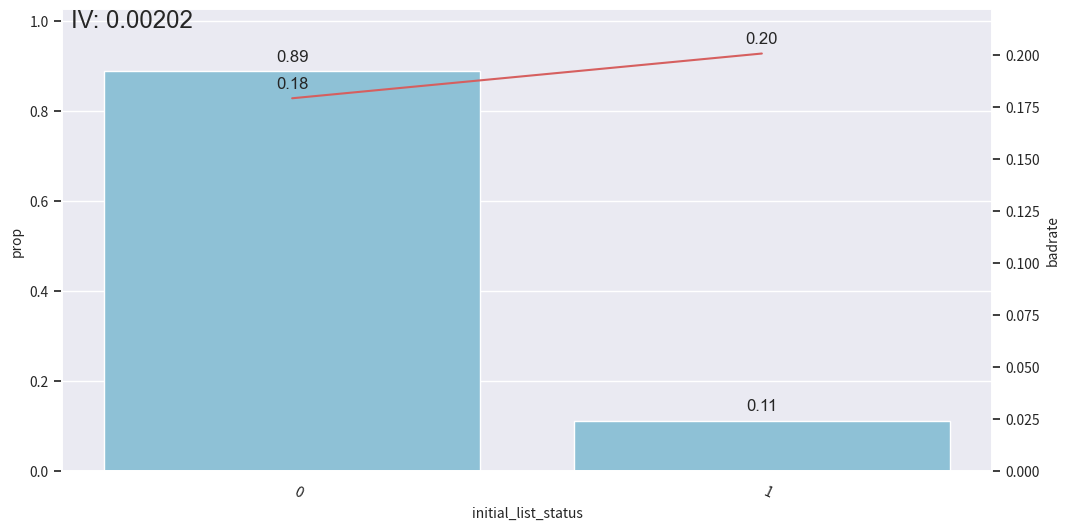

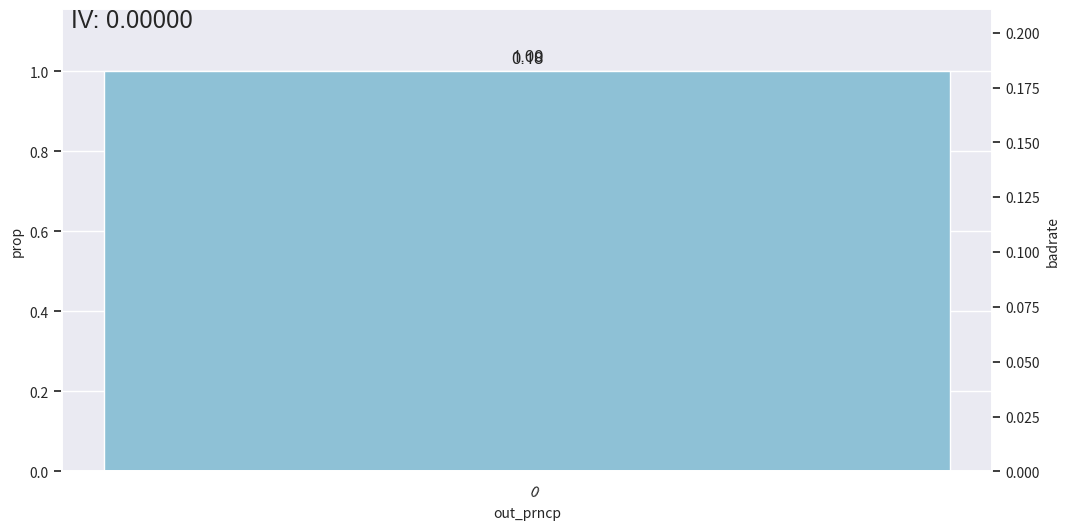

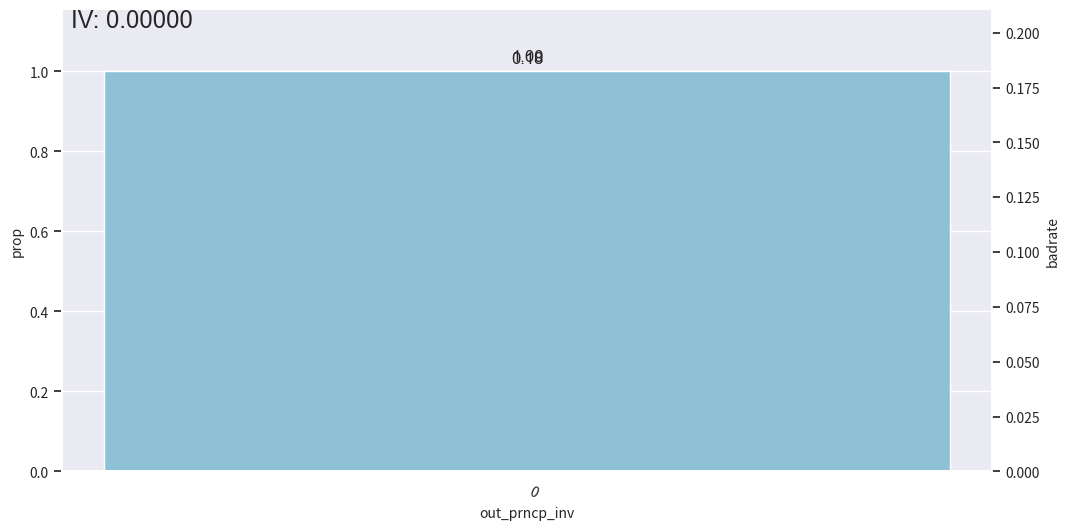

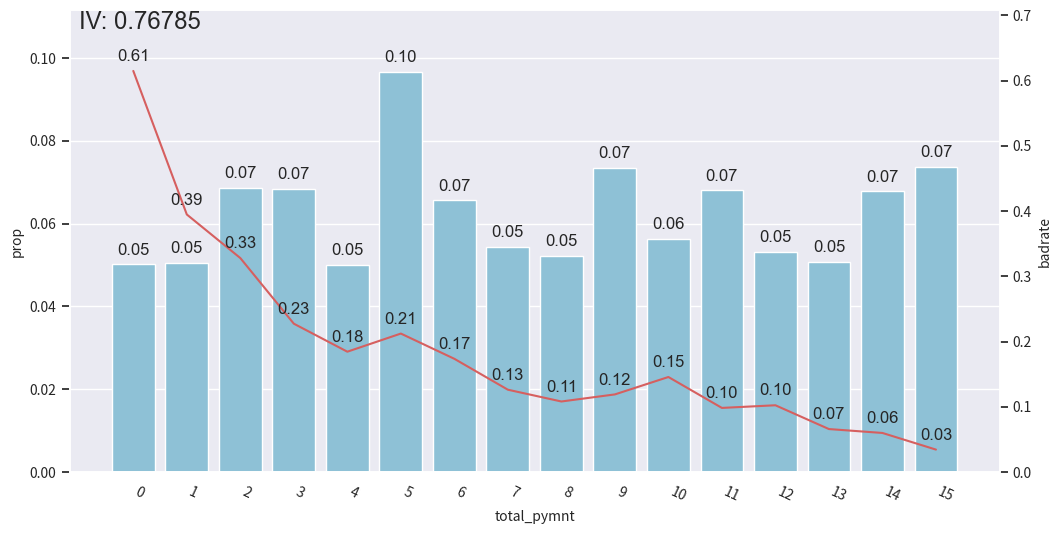

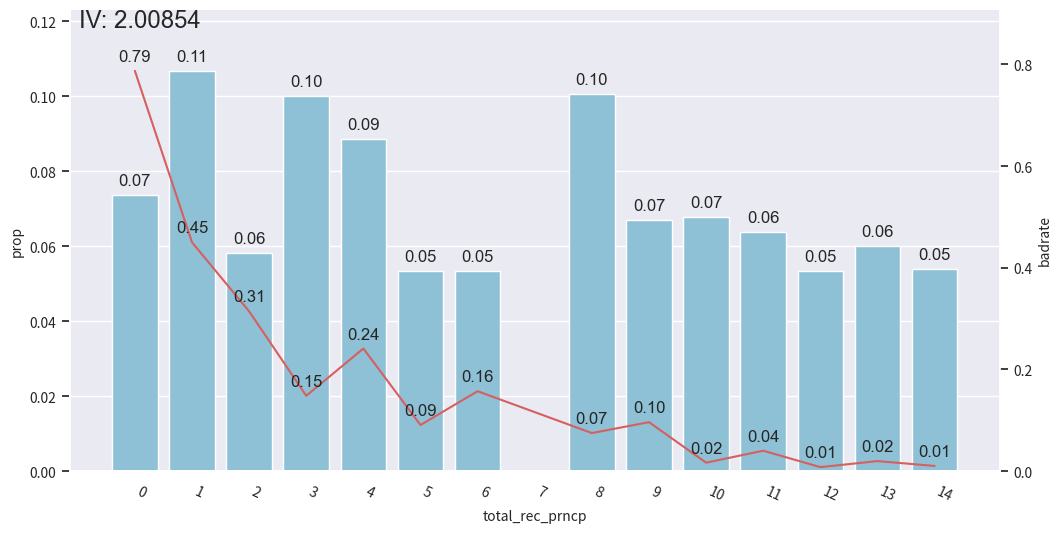

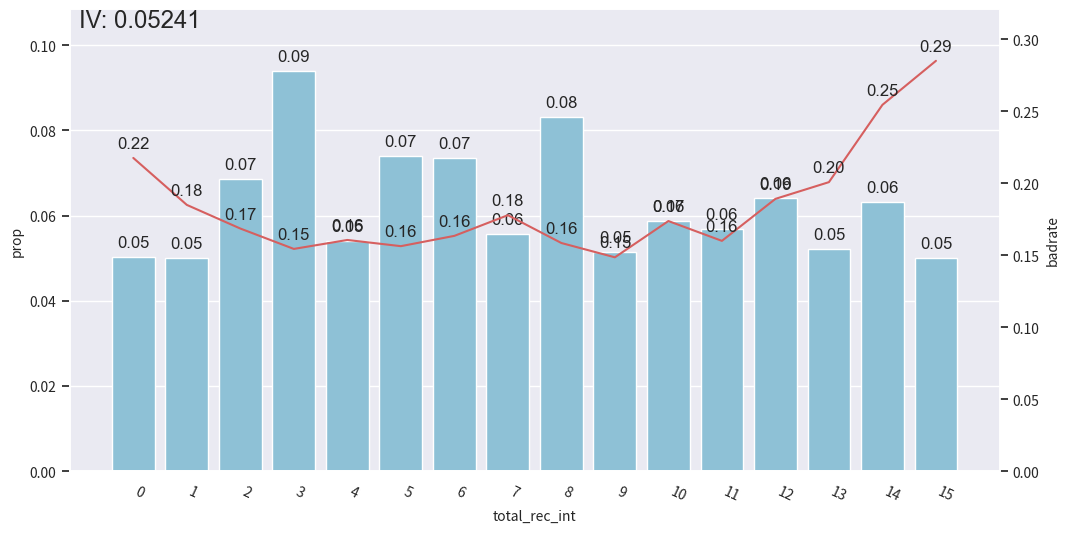

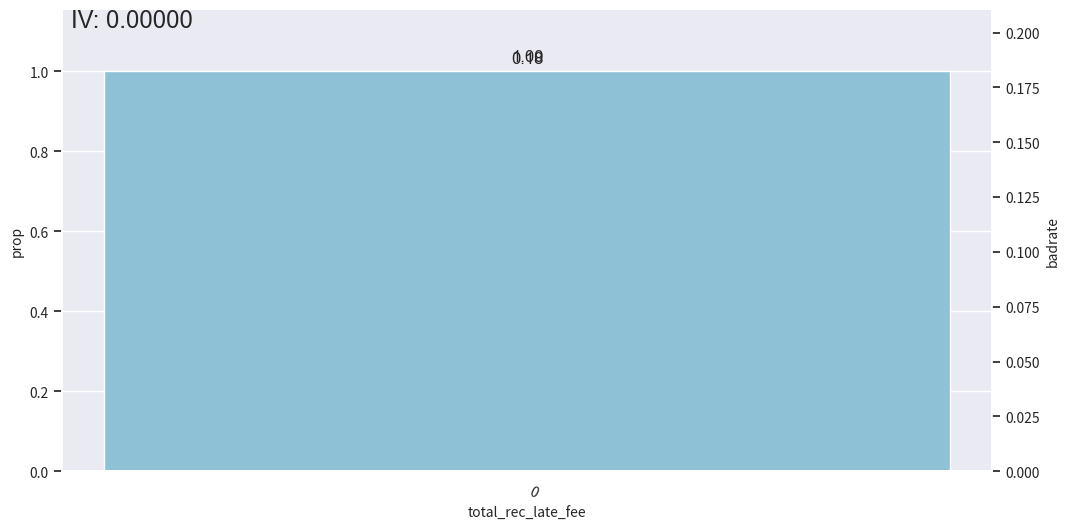

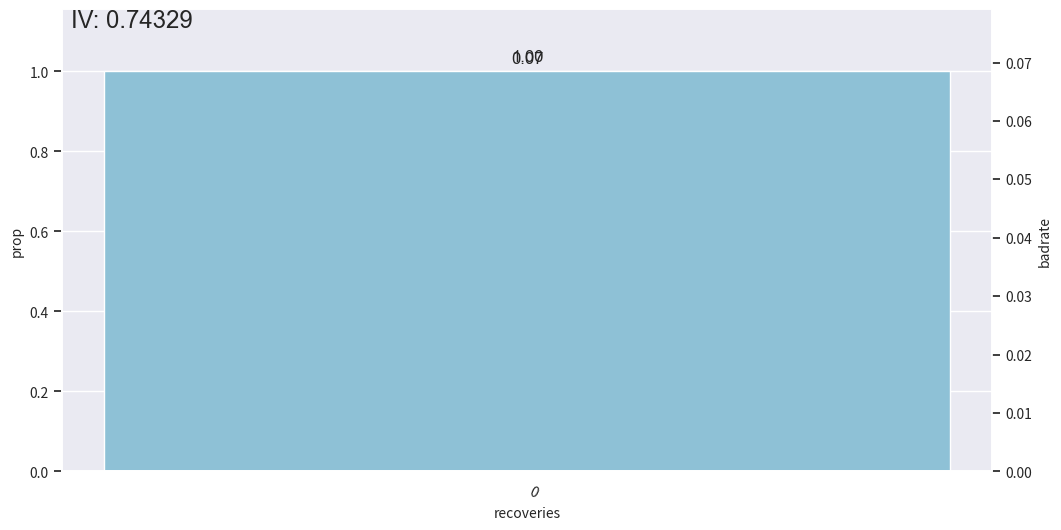

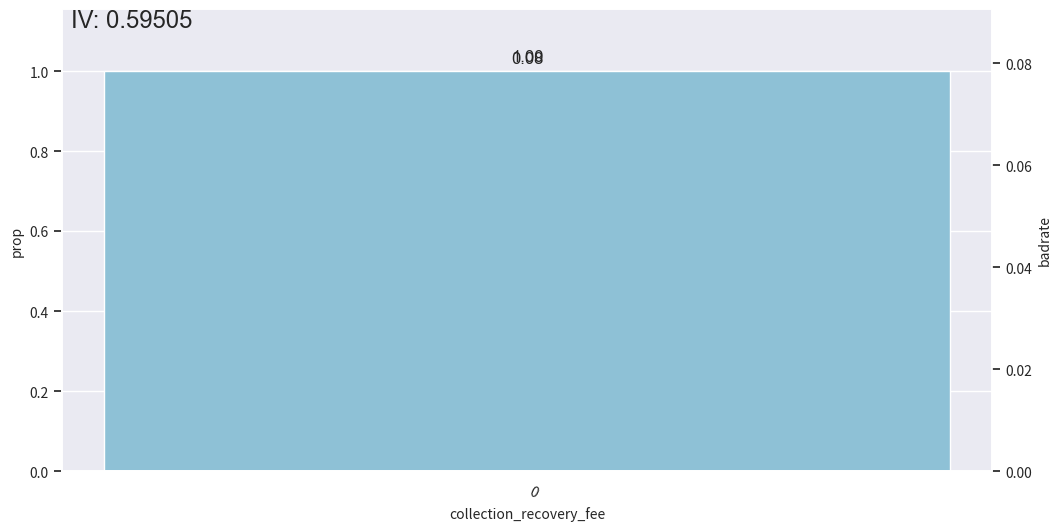

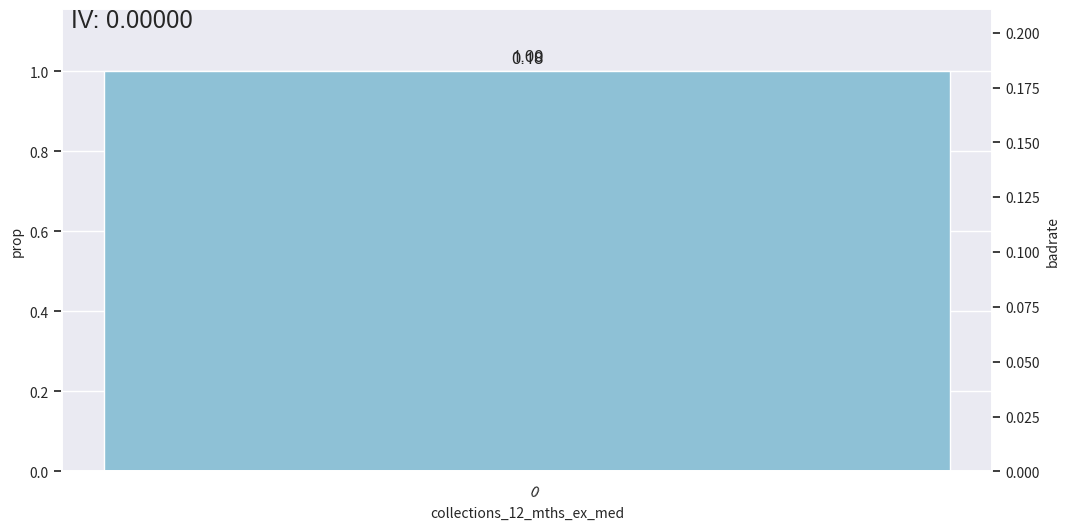

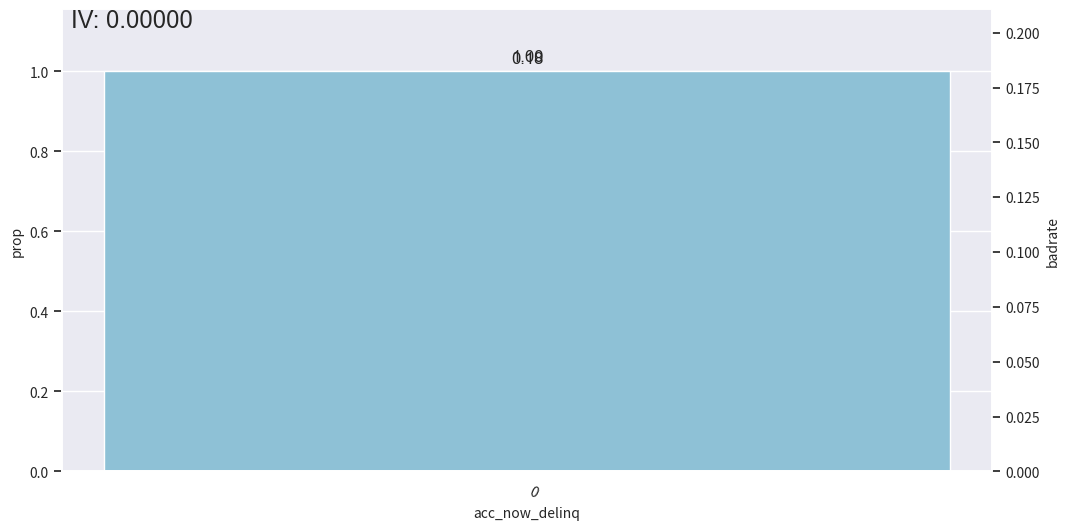

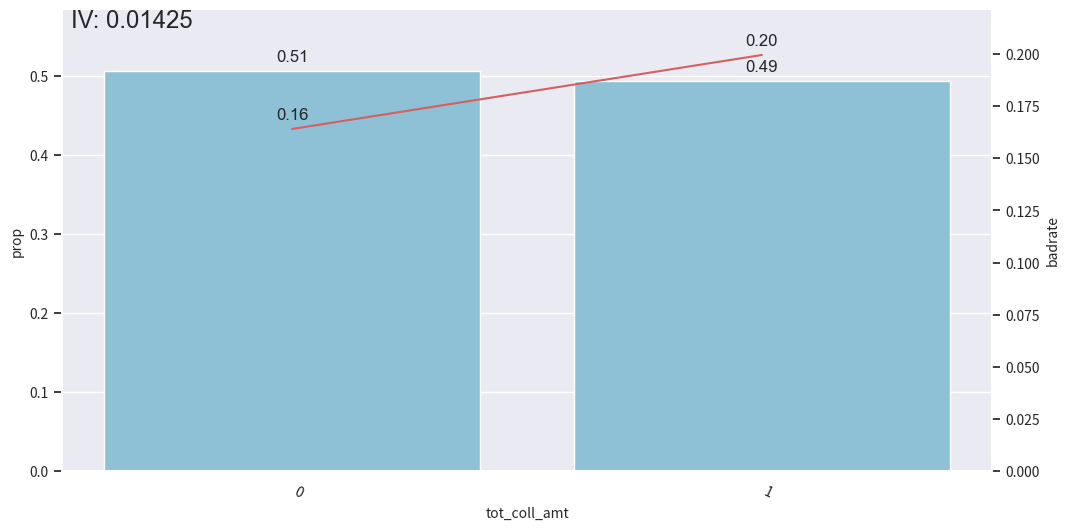

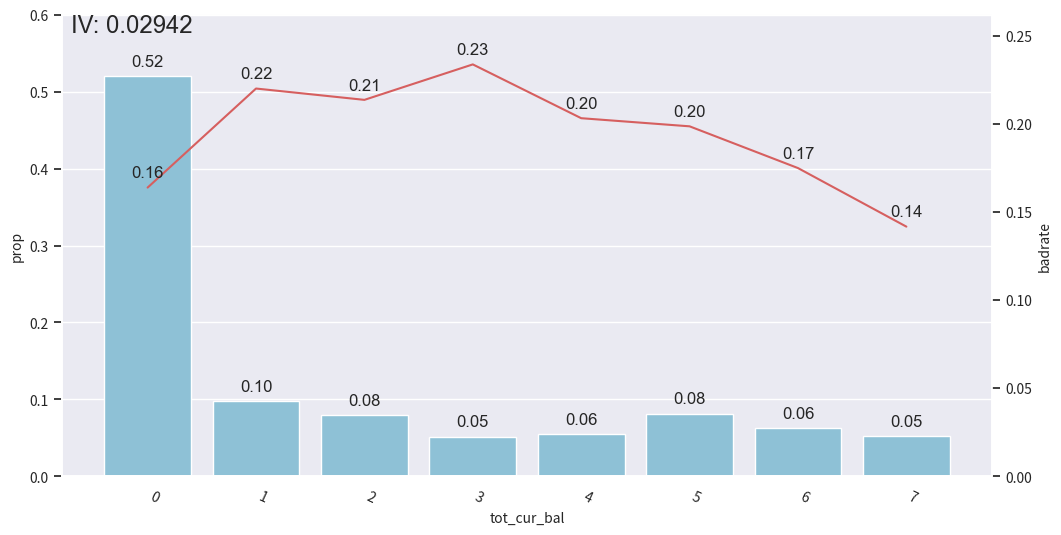

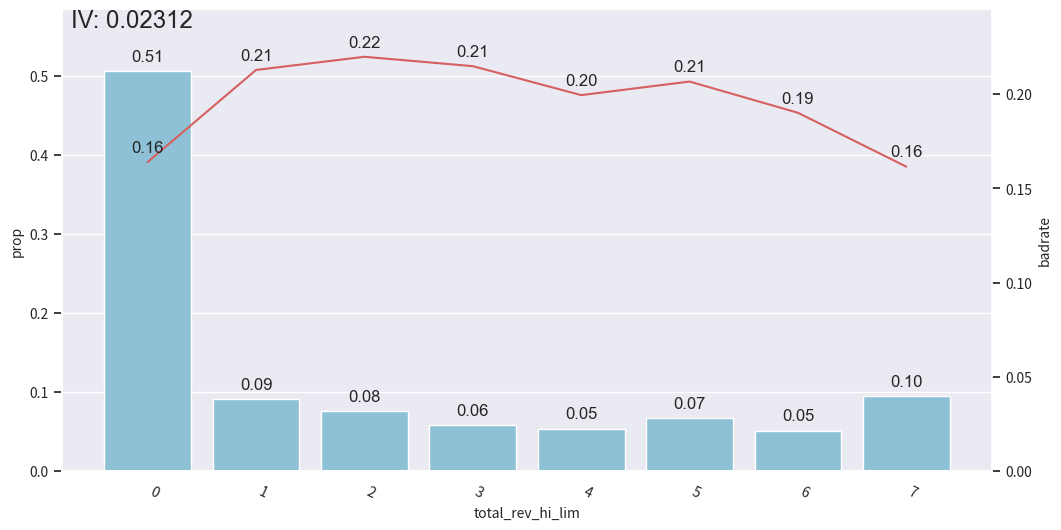

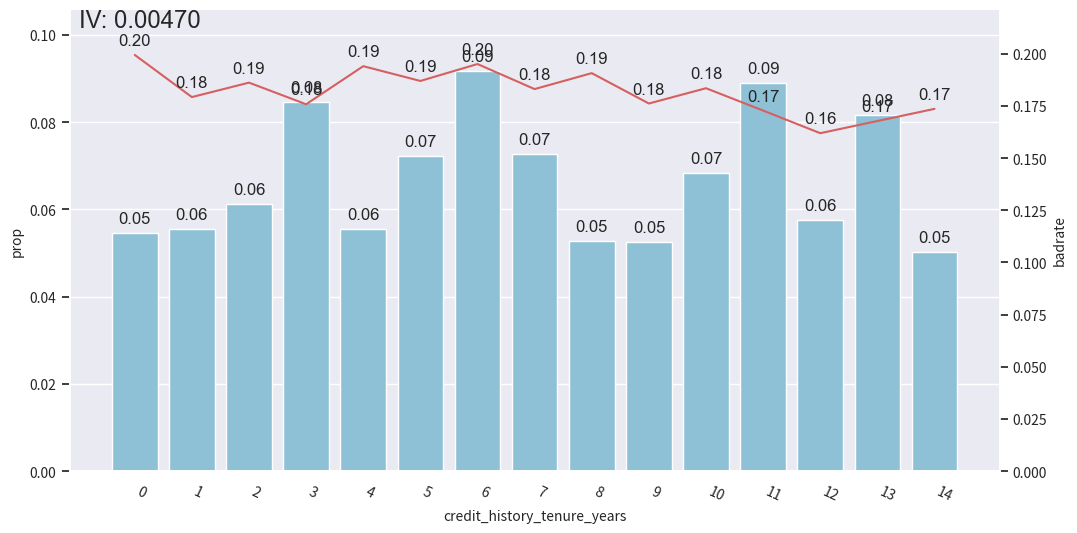

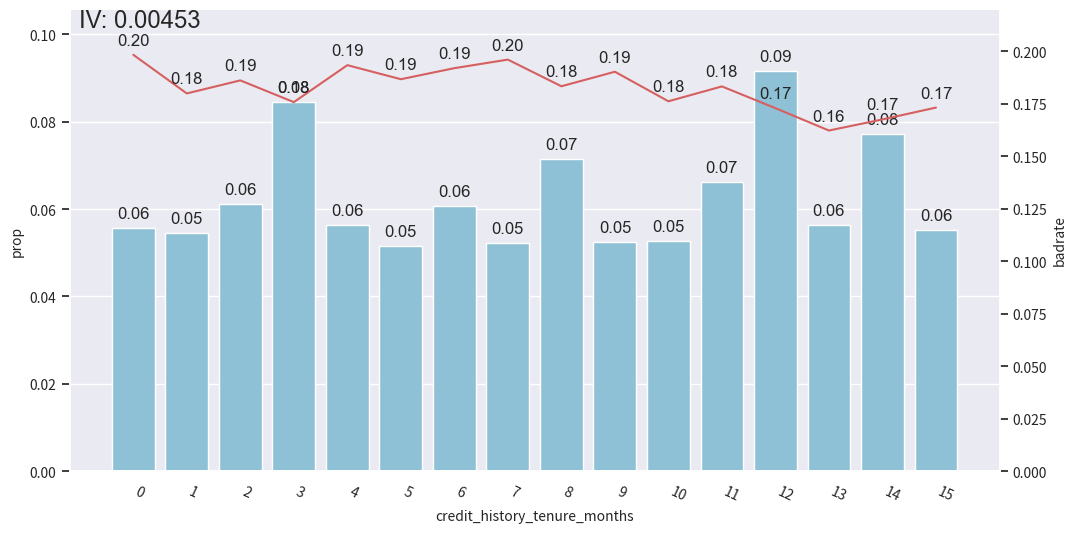

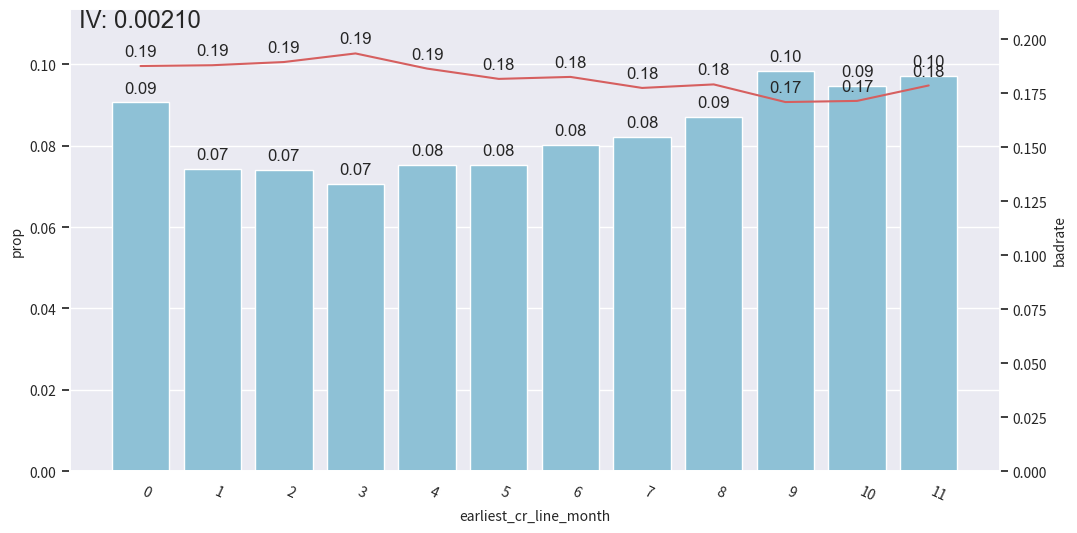

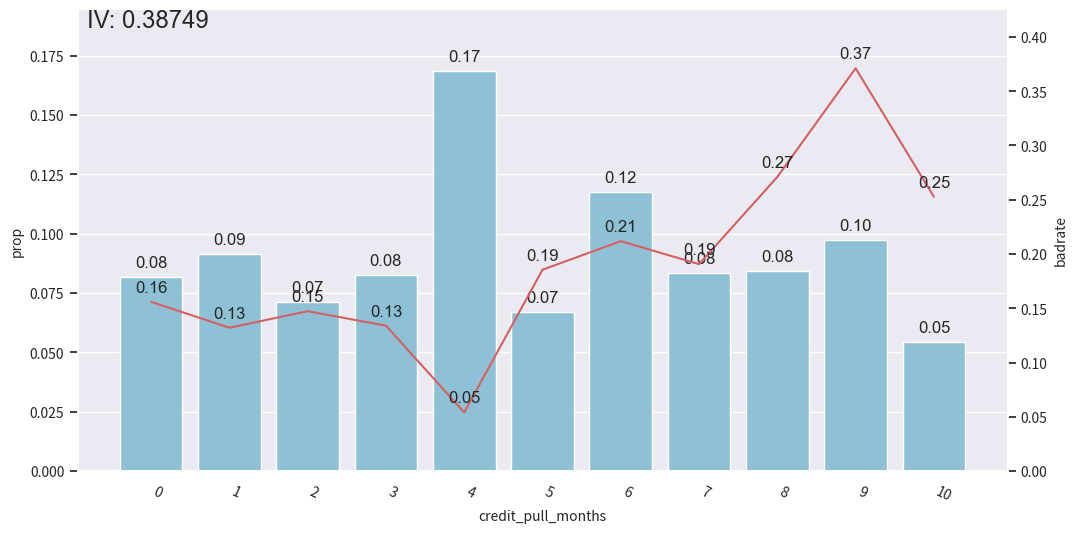

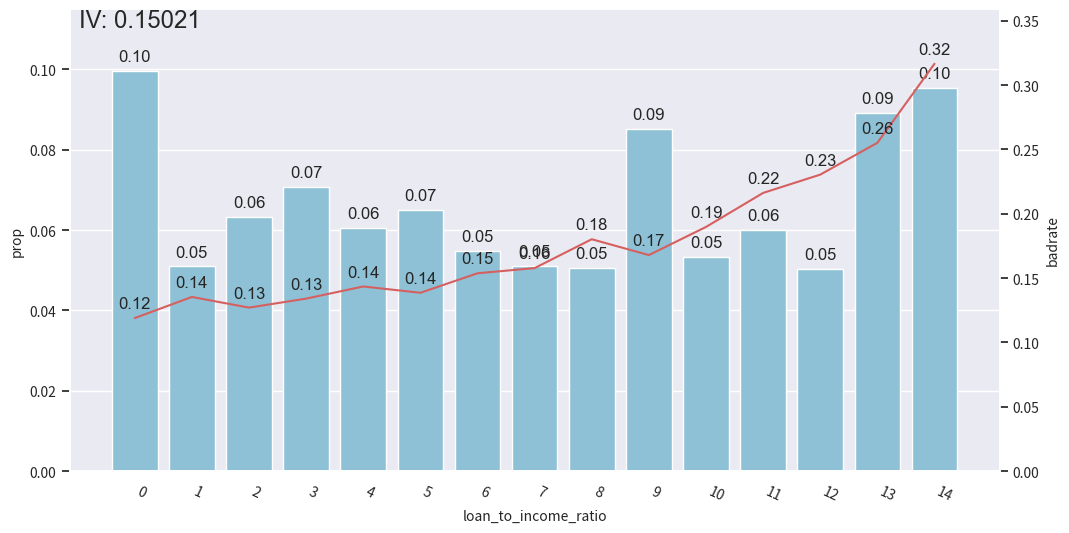

In [154]:
from toad.plot import  bin_plot
for col in X_train.columns:
    if col != 'loan_status':
        toad.plot.bin_plot(X_train, x=col, target=y_train)

In [224]:
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=X_train,
                            y=y_train)
#transform testing set
test_woe = t.transform(X_test[X_train.columns]) 

In [225]:
train_woe

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,credit_history_tenure_years,credit_history_tenure_months,earliest_cr_line_month,credit_pull_months,loan_to_income_ratio
0,0.117955,0.262746,0.488859,0.125947,0.500027,-0.083688,-0.080729,-0.233507,-0.233911,0.216810,-0.464194,0.013837,-0.061387,0.034165,0.015767,-0.032938,-0.214403,-0.057112,0.016348,0.0,0.0,-0.282923,0.244040,0.194717,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,0.095573,0.097009,-0.039811,0.376825,0.008705
1,0.177246,-0.817616,-0.168278,0.162343,-0.340975,0.064949,-0.080729,-0.145531,0.017870,0.437290,0.376762,0.013837,-0.350717,0.034165,0.015767,0.238823,0.593206,-0.057112,0.016348,0.0,0.0,-1.973808,-2.815843,0.090038,0.0,-11.054848,-10.974032,0.0,0.0,0.122622,0.123314,0.122819,-0.088675,-0.094977,-0.077572,-0.516555,0.348419
2,0.177246,0.262746,-0.395203,0.162343,-0.387960,-0.083688,-0.080729,-0.233507,0.280233,-0.313516,0.303209,0.013837,-0.183030,0.034165,0.015767,0.111546,-0.394447,-0.062987,0.016348,0.0,0.0,-1.078891,-1.305735,0.090038,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.082118,-0.078101,0.069944,0.376825,0.168674
3,0.054615,0.262746,0.117579,-0.177132,0.004088,-0.083688,-0.080729,-0.159007,0.017870,-0.313516,-0.044974,0.013837,-0.061387,-0.043165,0.015767,0.039216,0.444792,0.019516,0.016348,0.0,0.0,0.604151,7.360050,0.240175,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.013088,-0.011848,-0.042214,1.356364,0.008705
5,0.117955,0.262746,1.038432,0.125947,1.075294,0.033078,-0.080729,-0.241520,0.017870,0.437290,0.094875,0.013837,-0.350717,0.015835,0.015767,-0.082304,0.242080,-0.048595,0.016348,0.0,0.0,-0.282923,0.244040,0.194717,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.030854,-0.030854,0.069944,0.376825,0.280476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230651,0.299973,0.262746,1.038432,0.109011,1.075294,0.033078,0.088894,-0.208123,0.280233,0.216810,0.197976,0.013837,0.176320,0.015835,0.015767,-0.032938,0.057802,-0.030556,0.016348,0.0,0.0,0.496203,1.010874,0.147877,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.082118,-0.078101,-0.077572,-0.060119,-0.218369
230652,-0.065415,0.262746,-0.517476,-0.153262,-0.449638,-0.075985,-0.080729,-0.146537,0.017870,-0.071659,0.092697,-0.088642,-0.350717,-0.043165,0.015767,-0.115969,-0.063382,-0.006774,0.016348,0.0,0.0,1.247879,3.363871,-0.431331,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,0.095573,0.097009,0.073689,0.376825,-0.435079
230653,0.082774,0.262746,-0.168278,-0.351654,-0.340975,0.033078,-0.080729,-0.072310,0.017870,-0.313516,0.303209,-0.088642,-0.061387,-0.118948,0.015767,-0.038196,0.161560,0.003425,0.016348,0.0,0.0,0.665671,2.588514,-0.050488,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.030854,-0.030854,-0.039811,-0.026627,-0.054659
230654,-0.446958,0.262746,-0.395203,-0.227520,-0.387960,0.033078,0.088894,0.429454,0.017870,-0.313516,0.401763,0.013837,-0.061387,0.015835,0.015767,0.005281,-0.006578,-0.031839,0.016348,0.0,0.0,1.829637,3.092488,-0.586667,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.036169,-0.034587,0.017116,-0.026627,0.094431


## Information Value

In [226]:
quality=toad.quality(train_woe,target=y_train)
quality

droplist= quality[(quality['iv']<0.02) | (quality['iv']>=0.5)].index.tolist()
droplist

['recoveries',
 'collection_recovery_fee',
 'total_rec_prncp',
 'total_pymnt',
 'tot_coll_amt',
 'revol_bal',
 'home_ownership',
 'emp_length',
 'credit_history_tenure_years',
 'credit_history_tenure_months',
 'open_acc',
 'pub_rec',
 'earliest_cr_line_month',
 'total_acc',
 'initial_list_status',
 'delinq_2yrs',
 'acc_now_delinq',
 'collections_12_mths_ex_med',
 'out_prncp_inv',
 'out_prncp',
 'total_rec_late_fee']

In [227]:
train_woe.drop(columns=droplist, inplace=True)
test_woe.drop(columns=droplist, inplace=True)

In [228]:
train_woe

,loan_amnt,term,int_rate,installment,sub_grade,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,total_rec_int,tot_cur_bal,total_rev_hi_lim,credit_pull_months,loan_to_income_ratio
0,0.117955,0.262746,0.488859,0.125947,0.500027,-0.233507,-0.233911,0.216810,-0.464194,-0.061387,-0.214403,0.194717,0.123314,0.122819,0.376825,0.008705
1,0.177246,-0.817616,-0.168278,0.162343,-0.340975,-0.145531,0.017870,0.437290,0.376762,-0.350717,0.593206,0.090038,0.123314,0.122819,-0.516555,0.348419
2,0.177246,0.262746,-0.395203,0.162343,-0.387960,-0.233507,0.280233,-0.313516,0.303209,-0.183030,-0.394447,0.090038,0.123314,0.122819,0.376825,0.168674
3,0.054615,0.262746,0.117579,-0.177132,0.004088,-0.159007,0.017870,-0.313516,-0.044974,-0.061387,0.444792,0.240175,0.123314,0.122819,1.356364,0.008705
5,0.117955,0.262746,1.038432,0.125947,1.075294,-0.241520,0.017870,0.437290,0.094875,-0.350717,0.242080,0.194717,0.123314,0.122819,0.376825,0.280476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230651,0.299973,0.262746,1.038432,0.109011,1.075294,-0.208123,0.280233,0.216810,0.197976,0.176320,0.057802,0.147877,0.123314,0.122819,-0.060119,-0.218369
230652,-0.065415,0.262746,-0.517476,-0.153262,-0.449638,-0.146537,0.017870,-0.071659,0.092697,-0.350717,-0.063382,-0.431331,0.123314,0.122819,0.376825,-0.435079
230653,0.082774,0.262746,-0.168278,-0.351654,-0.340975,-0.072310,0.017870,-0.313516,0.303209,-0.061387,0.161560,-0.050488,0.123314,0.122819,-0.026627,-0.054659
230654,-0.446958,0.262746,-0.395203,-0.227520,-0.387960,0.429454,0.017870,-0.313516,0.401763,-0.061387,-0.006578,-0.586667,0.123314,0.122819,-0.026627,0.094431


## Population Stability Index(PSI)

In [229]:
psi_df=toad.metrics.PSI(train_woe,test_woe).sort_values()
psi_df=psi_df.reset_index()
psi_df=psi_df.rename(columns={'index':'feature', 0:'psi_value'})
psi_df

,feature,psi_value
0,inq_last_6mths,0.000959
1,total_rec_int,0.009029
2,term,0.017725
3,loan_to_income_ratio,0.019666
4,annual_inc,0.020385
5,dti,0.022841
6,revol_util,0.032254
7,loan_amnt,0.041573
8,verification_status,0.047121
9,installment,0.057089


In [230]:
#The industry level is to drop features with a PSI greater than 0.2
col_keep = list(set(list(psi_df[psi_df.psi_value<0.2].feature)))
train_psi = train_woe[col_keep]

print("keep:", train_psi.shape[1])



keep: 12


# Drop Highly Correlated features

In [231]:
train_psi, drop_lst = toad.selection.select(train_psi,
                                               y_train,
                                               corr=0.7, 
                                               return_drop=True, 
                                               )  
print("keep:", train_psi.shape[1],  
      "drop corr:", len(drop_lst['corr'])) 

keep: 12 drop corr: 0


## Step wise regression

In [232]:
train_stp = toad.selection.stepwise(train_psi,   y_train,  
             direction='both',   criterion='aic',  estimator='ols',intercept=False)  
print("keep:", train_stp.shape[1])

## ensure the features selected also apply to the test

test_stp = test_woe[train_stp.columns]  

keep: 11


# Train ,Test split

In [233]:
X_train, y_train = train_stp, y_train
X_test, y_test = test_stp, y_test

# SMOTE

In [234]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [49]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [100, 200, 300]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': [100, 200, 300]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'max_iter': [100, 200, 300]}
]

# Initialize logistic regression model
logistic_reg = LogisticRegression(max_iter=1000)

# Initialize GridSearchCV
grid_search = GridSearchCV(logistic_reg, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score: 0.6324574615676823
Test Accuracy: 0.6055268902560031


In [235]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42,C= 0.01, penalty='l2', solver='newton-cg',max_iter=100)



lr.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=42, solver='newton-cg')

In [236]:
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_[0]
})

coefficients_df.reindex(coefficients_df['Coefficient'].sort_values(ascending=False).index)

,Feature,Coefficient
5,annual_inc,1.196142
10,sub_grade,0.708437
4,purpose,0.642201
0,term,0.563960
9,inq_last_6mths,0.477341
3,dti,0.446286
8,loan_amnt,0.341743
1,revol_util,0.281455
7,loan_to_income_ratio,0.252964
2,verification_status,0.036451


<AxesSubplot:title={'center':'Confusion Matrix'}>

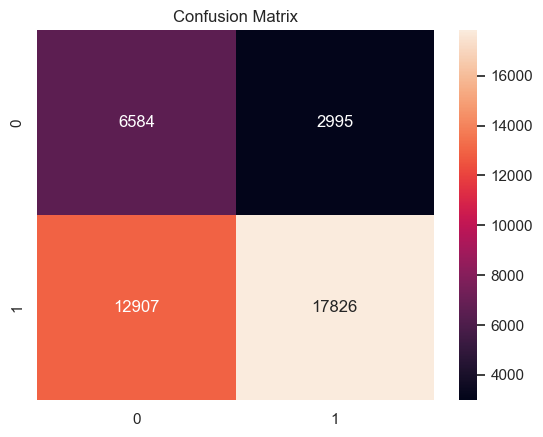

In [237]:
predictions=lr.predict(X_test)

cm=confusion_matrix(y_test,predictions)
plt.title('Confusion Matrix')
sns.heatmap(cm,annot=True,fmt="g")

In [169]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.58      0.69     30733
           1       0.34      0.69      0.45      9579

    accuracy                           0.61     40312
   macro avg       0.60      0.63      0.57     40312
weighted avg       0.73      0.61      0.64     40312



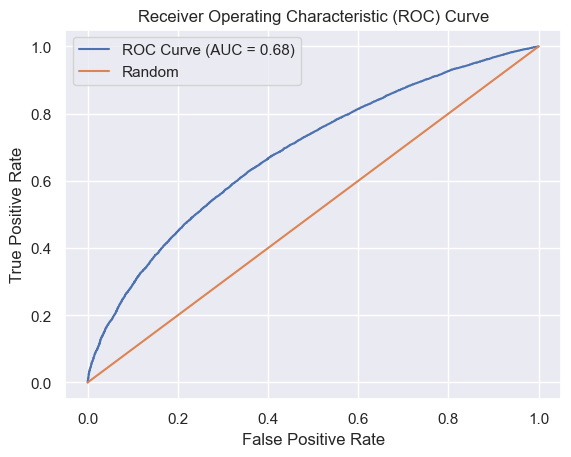

In [238]:
y_test_prob=lr.predict_proba(X_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_test_prob)
auc=roc_auc_score(y_test,y_test_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1],label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [239]:
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,#
    class_weight = 'balanced', #Adjusts weights for classes if the dataset has more "good" or "bad" cases. Prevents the model from being biased toward the majority class.
    C=0.01, #Regularization strength.Smaller C means stronger regularization, preventing overfitting.
    base_score = 800, # starting score : The score given when a customer has the baseline odds
    
    base_odds = 35 ,#The odds (good:bad) corresponding to the base score.For a score of 800, the odds of good vs. bad are 35:1
    pdo = 20, #For every doubling of the odds of repayment, the score increases by 20 points.
    rate = 2 #Odds doubling rate, Tells the scorecard that a doubling of odds corresponds to the PDO value. A rate of 2 literally means "double the odds." 
)


card.fit(X_train, y_train)
final_card = card.export(to_frame=True)  

In [240]:
final_card

,name,value,score
0,term,60 months,76.68
1,term,36 months,59.12
2,revol_util,[-inf ~ 18.25),58.51
3,revol_util,[18.25 ~ 26.449999809265137),59.73
4,revol_util,[26.449999809265137 ~ 33.04999923706055),61.40
...,...,...,...
112,sub_grade,B3,55.81
113,sub_grade,"B2,B1",53.17
114,sub_grade,A5,46.56
115,sub_grade,"A4,A3",41.41


In [241]:
final_card.to_csv('scorecard.csv')

In [242]:
test['CreditScore'] = card.predict(X_test)

In [257]:
test.sample(10)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,credit_history_tenure_years,credit_history_tenure_months,earliest_cr_line_month,credit_pull_months,loan_to_income_ratio,CreditScore
80957,6975,36 months,17.10,249.03,C5,9.0,MORTGAGE,55000.00,Verified,2013-10-01,1,debt_consolidation,15.69,1.0,2.0,10.0,0.0,4008,28.2,33.0,f,0.0,0.0,8487.050983,6975.0,1512.05,0.0,0.0,0.0,1.0,0.0,212.0,136728.0,14200.0,12.251882,147,7.0,-27,0.126818,647.372337
115227,24000,60 months,11.55,528.43,B3,10.0,MORTGAGE,86500.00,Verified,2013-07-01,1,debt_consolidation,20.42,0.0,0.0,15.0,0.0,20880,52.3,31.0,f,0.0,0.0,28221.872230,24000.0,4221.87,0.0,0.0,0.0,0.0,0.0,0.0,269668.0,39911.0,14.663929,176,11.0,-21,0.277457,640.526326
75868,30000,60 months,17.76,757.90,D1,10.0,MORTGAGE,90000.00,Source Verified,2013-10-01,1,small_business,0.33,0.0,0.0,2.0,0.0,2266,8.1,13.0,f,0.0,0.0,35861.601630,30000.0,5823.70,37.9,0.0,0.0,0.0,0.0,0.0,199734.0,28000.0,19.832991,238,12.0,-14,0.333333,640.526326
68481,11000,36 months,11.99,365.31,B3,4.0,MORTGAGE,56000.00,Verified,2013-11-01,1,debt_consolidation,25.74,0.0,0.0,8.0,0.0,3392,66.5,27.0,f,0.0,0.0,12064.292550,11000.0,1064.29,0.0,0.0,0.0,0.0,0.0,0.0,368280.0,5100.0,11.000684,132,11.0,-26,0.196429,642.710341
57931,15850,60 months,23.40,450.47,E5,3.0,MORTGAGE,52000.00,Verified,2013-11-01,1,debt_consolidation,17.24,1.0,1.0,11.0,0.0,9205,34.3,23.0,f,0.0,0.0,20028.934020,15850.0,4178.93,0.0,0.0,0.0,0.0,0.0,0.0,60895.0,18900.0,11.504449,138,5.0,-26,0.304808,640.526326
121207,25000,36 months,12.35,834.55,B4,5.0,MORTGAGE,60000.00,Verified,2013-07-01,1,debt_consolidation,11.36,2.0,0.0,11.0,0.0,2198,15.9,33.0,f,0.0,0.0,26673.520000,25000.0,1673.52,0.0,0.0,0.0,0.0,0.0,0.0,120791.0,13800.0,26.250513,315,4.0,-29,0.416667,640.526326
44911,15000,36 months,11.99,498.15,B3,10.0,OWN,84999.61,Source Verified,2013-12-01,1,debt_consolidation,20.33,0.0,1.0,16.0,0.0,12633,49.0,31.0,f,0.0,0.0,17050.093900,15000.0,2050.09,0.0,0.0,0.0,0.0,0.0,0.0,126642.0,25800.0,18.502396,222,6.0,-17,0.176471,644.111459
67476,22000,36 months,7.90,688.39,A4,10.0,MORTGAGE,95000.00,Verified,2013-11-01,1,debt_consolidation,12.06,0.0,0.0,19.0,0.0,21694,21.0,45.0,f,0.0,0.0,23172.143000,22000.0,1172.14,0.0,0.0,0.0,0.0,0.0,0.0,108137.0,103400.0,16.503765,198,5.0,-9,0.231579,641.080808
46175,10000,36 months,13.98,341.68,C1,6.0,RENT,56000.00,Verified,2013-12-01,1,debt_consolidation,33.11,0.0,1.0,12.0,1.0,3877,38.0,24.0,f,0.0,0.0,11780.546800,10000.0,1780.55,0.0,0.0,0.0,0.0,0.0,0.0,35129.0,10200.0,11.830253,142,2.0,-20,0.178571,644.111459
87726,35000,60 months,21.00,946.87,E1,10.0,MORTGAGE,85000.00,Verified,2013-09-01,1,debt_consolidation,13.28,1.0,1.0,10.0,0.0,9508,45.1,24.0,f,0.0,0.0,39171.957300,35000.0,4171.96,0.0,0.0,0.0,0.0,0.0,0.0,276053.0,21100.0,18.001369,216,9.0,-22,0.411765,640.526326


# Evaluation

# Kolmogorov–Smirnov (KS) - Evaluation


In [244]:
# Predict scores on the test set
scores = card.predict(X_test)

# Calculate K-S statistic
ks_value = toad.metrics.KS(scores, y_test)
print(f"K-S Statistic: {ks_value:.4f}")


K-S Statistic: 0.1594


# Interpretation

- The maximum difference between the cumulative distributions of good vs. bad cases is only 15.94%, indicating that the model does not strongly differentiate between them.
- This suggests that the model might need improvement (e.g., better feature selection, different binning strategies etc).

In [245]:
from sklearn.metrics import roc_auc_score

# Generate scorecard scores
y_test_score =card.predict(X_test)  # Final credit scores

# Compute AUC
auc = roc_auc_score(y_test, y_test_score)

# Compute Gini coefficient
gini = 2 * auc - 1
print(f"Gini Coefficient (on scorecard scores): {gini:.4f}")


Gini Coefficient (on scorecard scores): 0.1776


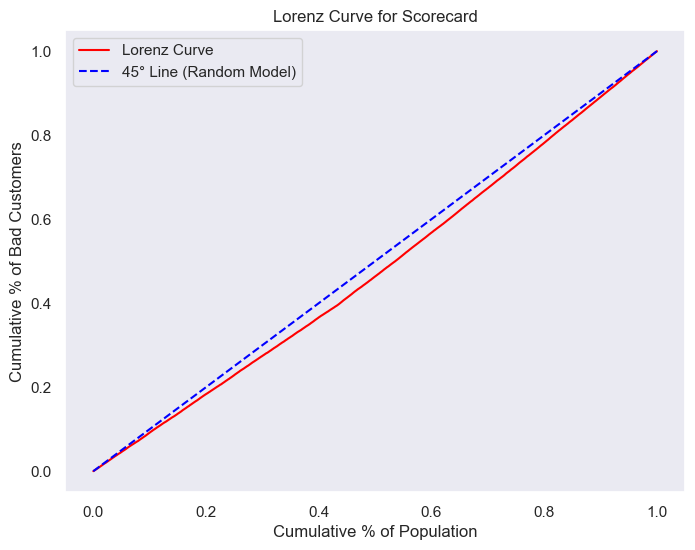

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example Data: Assume y_test contains actual labels (1 = good, 0 = bad)
# y_test_score contains predicted scores from the scorecard

# Step 1: Create a DataFrame
df = pd.DataFrame({'score': y_test_score, 'target': y_test})

# Step 2: Sort Data by Score (Lowest to Highest)
df = df.sort_values('score')

# Step 3: Compute Cumulative Population % and Cumulative Bad %
df['cumulative_population'] = np.arange(1, len(df) + 1) / len(df)
df['cumulative_bad'] = df['target'].cumsum() / df['target'].sum()

# Step 4: Plot Lorenz Curve
plt.figure(figsize=(8,6))
plt.plot(df['cumulative_population'], df['cumulative_bad'], label='Lorenz Curve', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label='45° Line (Random Model)')

plt.xlabel("Cumulative % of Population")
plt.ylabel("Cumulative % of Bad Customers")
plt.title("Lorenz Curve for Scorecard")
plt.legend()
plt.grid()

plt.show()


In [246]:
test['CreditScore'].max()

649.591569293169

In [247]:
test['CreditScore'].min()

640.52632649143

In [249]:
bin_edges = np.arange(min(y_test_score), max(y_test_score) + 3, 3)  # Fixed bin width = 3
bin_labels = [f"{int(low)}-{int(high)}" for low, high in zip(bin_edges[:-1], bin_edges[1:])]

# Step 2: Assign Scores to Bins
score_bins = pd.cut(y_test_score, bins=bin_edges, labels=bin_labels, include_lowest=True)

# Step 3: Group by Bins and Compute Default Rate (Bad Rate)
bin_summary = pd.DataFrame({'bin': score_bins, 'target': y_test})
bin_stats = bin_summary.groupby('bin')['target'].agg(['count', 'sum'])
bin_stats['default_rate'] = (1 - bin_stats['sum'] / bin_stats['count']) * 100  # Adjusted calculation

# Display results
bin_stats

,count,sum,default_rate
bin,,,
640-643,23390,16816,28.106028
643-646,4816,3885,19.331395
646-649,6936,5727,17.430796
649-652,5170,4305,16.731141


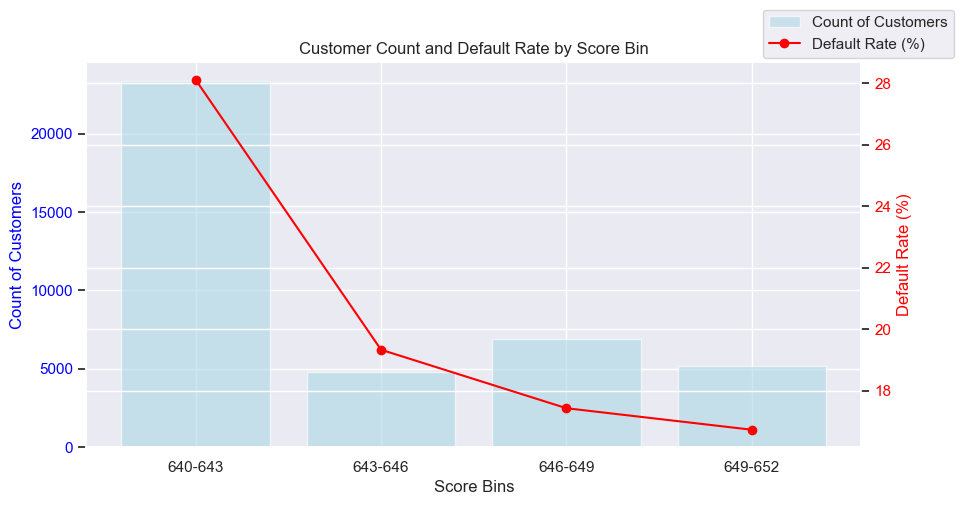

In [254]:

# Step 1: Define Fixed-Width Bins
bin_edges = np.arange(min(y_test_score), max(y_test_score) + 3, 3) 
bin_labels = [f"{int(low)}-{int(high)}" for low, high in zip(bin_edges[:-1], bin_edges[1:])]

# Step 2: Assign Scores to Bins
score_bins = pd.cut(y_test_score, bins=bin_edges, labels=bin_labels, include_lowest=True)

# Step 3: Group by Bins and Compute Default Rate (Bad Rate)
bin_summary = pd.DataFrame({'bin': score_bins, 'target': y_test})
bin_stats = bin_summary.groupby('bin')['target'].agg(['count', 'sum'])
bin_stats['default_rate'] = (1 - bin_stats['sum'] / bin_stats['count']) * 100  
bin_stats

# Step 4: Visualization
fig, ax1 = plt.subplots(figsize=(10,5))

# Bar chart for count of customers
ax1.bar(bin_stats.index.astype(str), bin_stats['count'], color='lightblue', alpha=0.6, label='Count of Customers')
ax1.set_xlabel("Score Bins")
ax1.set_ylabel("Count of Customers", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line chart for default rate
ax2 = ax1.twinx()  
ax2.plot(bin_stats.index.astype(str), bin_stats['default_rate'], color='red', marker='o', linestyle='-', label='Default Rate (%)')
ax2.set_ylabel("Default Rate (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title & Legend
plt.title("Customer Count and Default Rate by Score Bin")
fig.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.xticks(rotation=90)
plt.show()


In [255]:
bin_stats


,count,sum,default_rate
bin,,,
640-643,23390,16816,28.106028
643-646,4816,3885,19.331395
646-649,6936,5727,17.430796
649-652,5170,4305,16.731141
